In [91]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np
import os
import json
from collections import defaultdict

from scipy.stats import spearmanr, pearsonr

from regmixer.synthesize_mixture import calculate_priors
from regmixer.utils import config_from_path
from regmixer.eval.utils import (
    build_regression,
    get_output_dir,
    get_runs_from_api,
    mk_run_from_json,
    mk_run_metrics,
    mk_weights_from_config,
    mk_output_prefix,
    plot_correlation,
    plot_weights,
    simulate,
    simulate2,
    )


import pathlib
import wandb


from regmixer.eval.constants import GroupedWandbMetrics


from regmixer.eval.law import ScalingLaw

/home/mayee/miniconda3/envs/mayeeenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [3]:
config = "src/regmixer/config/dclm-datadelve-5xC-30m-dolma2tok-subset.yaml"
launch_config = config_from_path(config)


priors = calculate_priors(
        source_configs=launch_config.sources,
        dtype=launch_config.dtype,
        use_cache=True,
    )

2025-04-01 14:54:55,580 - regmixer.synthesize_mixture - INFO - Source distribution cache found, using cached values! This can be disabled by setting use_cache=False.


In [50]:
BASE_CACHE_DIR = "cache/"

experiment_groups = ["4318c7a9"]


cache_path = pathlib.Path(BASE_CACHE_DIR) / f"{'_'.join(experiment_groups)}_runs_cache.json"
api = wandb.Api() 

workspace = "ai2-llm/regmixer"

num_samples=1

group_metrics= 'arc_easy_new' #'mmlu_bpb_new' #'val_loss' #'mmlu_bpb_new'
eval_metric_group = GroupedWandbMetrics[group_metrics]
eval_metric_group_name = group_metrics

run_instances = get_runs_from_api(
        api, workspace, experiment_groups, cache_path, False, num_samples, eval_metric_group
    )
    
run_ratios = [
        {"run": run.id, "index": idx, **mk_weights_from_config(run.config, priors)}
        for idx, run in enumerate(run_instances)
    ]

2025-04-02 00:22:40,176 - regmixer.eval.utils - INFO - Collected RunInstance for dclm-datadelve-5xC-30m-subset-4318c7a9-0006:t8hg2qob with samples: (1, 1)
2025-04-02 00:22:40,178 - regmixer.eval.utils - INFO - Collected RunInstance for dclm-datadelve-5xC-30m-subset-4318c7a9-0001:cmd16vf1 with samples: (1, 1)
2025-04-02 00:22:40,179 - regmixer.eval.utils - INFO - Collected RunInstance for dclm-datadelve-5xC-30m-subset-4318c7a9-0007:v125yas0 with samples: (1, 1)
2025-04-02 00:22:40,180 - regmixer.eval.utils - INFO - Collected RunInstance for dclm-datadelve-5xC-30m-subset-4318c7a9-0008:wwwved4h with samples: (1, 1)
2025-04-02 00:22:40,181 - regmixer.eval.utils - INFO - Collected RunInstance for dclm-datadelve-5xC-30m-subset-4318c7a9-0004:6h3b05k4 with samples: (1, 1)
2025-04-02 00:22:40,182 - regmixer.eval.utils - INFO - Collected RunInstance for dclm-datadelve-5xC-30m-subset-4318c7a9-0003:z1ub9adn with samples: (1, 1)
2025-04-02 00:22:40,183 - regmixer.eval.utils - INFO - Collected RunIn

finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished


In [51]:
run_metrics = []
for idx, run in enumerate(run_instances):
    if len(run.samples) == 0:
        continue 
    entry =    {
        "run": run.id,
        "index": idx,
        **mk_run_metrics(
            history=run.samples,
            samples=num_samples,
            metrics=(eval_metric_group_name, eval_metric_group.value),
            average=False,
        ),
    }
    run_metrics.append(entry)


In [52]:
ratios = pd.DataFrame(run_ratios)
metrics = pd.DataFrame(run_metrics)
ratios = ratios[ratios['run'].isin(metrics.run)]

In [53]:
X = ratios[ratios.columns[2:]].values
Y = metrics[metrics.columns[2:]].values

In [56]:
ratios.iloc[3]

run              z1ub9adn
index                   3
politics              0.3
entertainment        0.25
health               0.45
Name: 3, dtype: object

In [54]:
Y.argmin()

3

# Inspect swarm mixtures

In [30]:
X.shape

(119, 24)

In [32]:
n_domains = X.shape[-1]

In [34]:
from collections import defaultdict
density = []

support_count = defaultdict(int)

for row in X:
    density.append(len(np.where(row != 0)[0]) / len(row))

    support_count[tuple(np.where(row != 0)[0])] += 1

density = np.array(density)
print(density.mean(), density.min(), density.max())


support_size = density * n_domains 
print(support_size.mean(), support_size.min(), support_size.max())

0.13935574229691872 0.041666666666666664 0.3333333333333333
3.3445378151260505 1.0 8.0


In [31]:
support_count

defaultdict(int,
            {(19, 23): 2,
             (4, 5, 13, 14): 1,
             (13, 14): 1,
             (21,): 1,
             (0, 9, 18, 19, 22): 1,
             (16, 23): 2,
             (0, 5, 14, 18): 1,
             (8, 23): 1,
             (1, 3, 14): 1,
             (1, 5, 20): 1,
             (2, 5, 7, 8, 10, 12, 20): 1,
             (2, 10, 13): 1,
             (1, 5, 6, 13, 21): 1,
             (0, 22): 1,
             (1, 5, 6, 8, 9): 1,
             (2, 8): 1,
             (5, 23): 2,
             (0, 6, 9): 1,
             (10, 23): 1,
             (19, 22): 1,
             (4, 5, 23): 1,
             (2, 14): 1,
             (0, 1, 2, 8, 21, 23): 1,
             (5, 10, 15, 21, 23): 1,
             (10, 21): 1,
             (9, 23): 1,
             (5, 9, 12): 1,
             (0, 2, 23): 1,
             (18, 22): 1,
             (6, 8, 10, 21, 23): 1,
             (2, 8, 11): 1,
             (0, 6, 7, 9): 1,
             (0, 2, 14): 1,
             (0, 19): 1,
 

In [67]:
for i, row in enumerate(X):
    support = tuple(np.where(row != 0)[0])
    if support_count[support] > 1:
        print(i, support, row[list(support)])


0 (12, 22) [0.35 0.65]
5 (2, 22) [0.85 0.15]
16 (18, 22) [0.5 0.5]
23 (18, 22) [0.2 0.8]
33 (2, 22) [0.3 0.7]
69 (12, 22) [0.25 0.75]


In [48]:
ratios.columns[2:][[12, 22]]

Index(['home_and_hobbies', 'health'], dtype='object')

In [42]:
ratios.iloc[[16, 23]]

,run,index,education_and_jobs,literature,transportation,software_development,industrial,software,social_life,religion,...,crime_and_law,finance_and_business,food_and_dining,fashion_and_beauty,entertainment,science_math_and_technology,sports_and_fitness,games,health,history_and_geography
16,1cy0qtmy,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0
23,swuv373r,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.8,0.0


In [37]:
ratios.iloc[[5, 33]]

,run,index,education_and_jobs,literature,transportation,software_development,industrial,software,social_life,religion,...,crime_and_law,finance_and_business,food_and_dining,fashion_and_beauty,entertainment,science_math_and_technology,sports_and_fitness,games,health,history_and_geography
5,iyr8a9nn,5,0.0,0.0,0.85,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.0
33,gkfm7f2n,33,0.0,0.0,0.30,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.70,0.0


In [46]:
ratios.iloc[[0, 73]]

,run,index,education_and_jobs,literature,transportation,software_development,industrial,software,social_life,religion,...,crime_and_law,finance_and_business,food_and_dining,fashion_and_beauty,entertainment,science_math_and_technology,sports_and_fitness,games,health,history_and_geography
0,evt5quxd,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65,0.0
73,7lxtrlhb,73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0


# Fit things

Warning: this fitting law doesn't use $k_i$, because we effectively do the same when we have one weight per $p_i$, including the last $p_k = 1 - all others$

In [18]:
indices = np.where(np.any(X == 0, axis=1))[0]


In [24]:
indices = np.where(~np.any(X == 0, axis=1))[0]
X = X[indices]
Y = Y[indices]

In [45]:
import torch
from regmixer.eval.law import ScalingLaw

def mixing_law(x, param):
    log_c_i = param[0]
    t_i = param[1:]
    result = torch.exp(log_c_i) + torch.exp(torch.matmul(x, t_i))
    return result

def init_params_law(idx, num_domains=3):
    for log_c_i in np.linspace(-2, 1.5, 10):
        for _ in range(30):
            ts = [-np.random.rand() if i == idx else np.random.rand() * 0.1 for i in range(num_domains)]
            yield [log_c_i] + ts


In [46]:
def calculate_r_squared(actuals, predictions):
    actuals, predictions = actuals.numpy(), predictions.numpy()
    # Calculate the total sum of squares
    total_sum_of_squares = np.sum((actuals - np.mean(actuals)) ** 2)
    # Calculate the residual sum of squares
    residual_sum_of_squares = np.sum((actuals - predictions) ** 2)
    # Calculate R-squared
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r_squared

In [47]:
domains = ratios.columns[2:].values

0


100%|██████████| 300/300 [00:10<00:00, 29.03it/s]
/tmp/ipykernel_2953460/2805919464.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r2_train = calculate_r_squared(torch.tensor(y), torch.tensor(prediction_train))


min loss: 0.00018002837896347046
0.9423059723711135
RMSE: 0.021045172930669837, MAE: 0.016915537416934967, MSE: 0.00044289929792284966, R2: 0.8861629125224356
0.00044289929792284966 0.0
0.8861629125224356 0.0


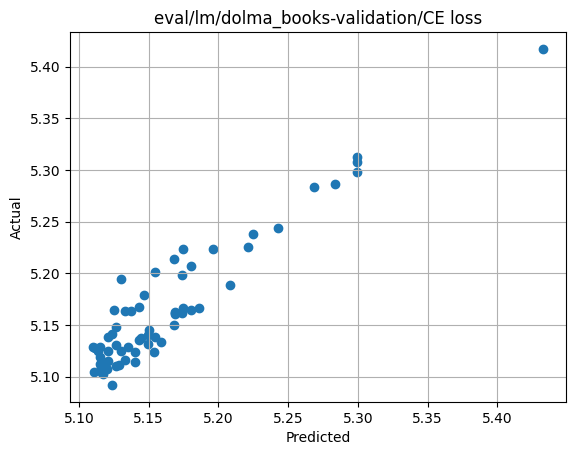

In [49]:
params = {}

mses = []
r2s = []

for i in range(Y.shape[-1]): # each task:
    y = Y[:, i]
        
    law = ScalingLaw(mixing_law)

    print(i)

    p = law.fit(X, y, init_params_law(i, num_domains=len(domains)), max_step=100, delta=0.02)
    params[i] = p

    prediction_train = mixing_law(torch.tensor(X, dtype=torch.float), torch.tensor(p, dtype=torch.float))
    rmse_train = (torch.mean((prediction_train - y)**2)**0.5).item()
    mae_train = torch.mean(torch.abs(prediction_train - y)).item()
    mse_train = torch.nn.functional.mse_loss(prediction_train, torch.tensor(y, dtype=torch.float)).item()


    r2_again = np.corrcoef(y, prediction_train)[0, 1]
    print(r2_again)
    r2_train = calculate_r_squared(torch.tensor(y), torch.tensor(prediction_train))

    mses.append(mse_train)
    r2s.append(r2_train)


    print(f"RMSE: {rmse_train}, MAE: {mae_train}, MSE: {mse_train}, R2: {r2_train}")

    plt.figure()
    plt.scatter(prediction_train, y)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid() 
    plt.title(eval_metric_group.value[i])

mses = np.array(mses)
r2s = np.array(r2s)

print(mses.mean(), mses.std())
print(r2s.mean(), r2s.std())

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

0


100%|██████████| 300/300 [00:24<00:00, 12.22it/s]
/tmp/ipykernel_222382/3476110816.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r2_train = calculate_r_squared(torch.tensor(y_train), torch.tensor(prediction_train))
/tmp/ipykernel_222382/3476110816.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r2_test = calculate_r_squared(torch.tensor(y_test), torch.tensor(prediction_test))
/tmp/ipykernel_222382/3476110816.py:75: RuntimeWarning: Mean of empty slice.
  print(mses.mean(), mses.std())
/home/mayee/miniconda3/envs/mayeeenv/lib/python3.13/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home

min loss: 0.0004914437886327505
R2: 0.905199134311839
nan nan
0.905199134311839 0.0


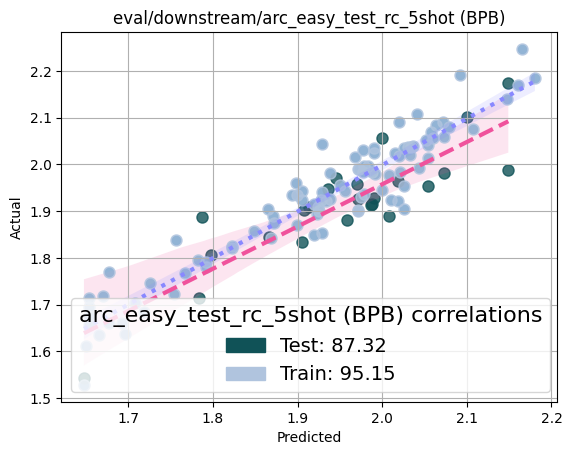

In [40]:
params = {}

mses = []
r2s = []

for i in range(Y.shape[-1]): # each task:
    y = Y[:, i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    law = ScalingLaw(mixing_law)

    print(i)

    p = law.fit(X_train, y_train, init_params_law(i, num_domains=len(domains)), max_step=100, delta=0.02)
    params[i] = p

    prediction_train = mixing_law(torch.tensor(X_train, dtype=torch.float), torch.tensor(p, dtype=torch.float))
    prediction_test = mixing_law(torch.tensor(X_test, dtype=torch.float), torch.tensor(p, dtype=torch.float))
    #rmse_train = (torch.mean((prediction_train - y_train)**2)**0.5).item()
    #mae_train = torch.mean(torch.abs(prediction_train - y)).item()
    #mse_train = torch.nn.functional.mse_loss(prediction_train, torch.tensor(y, dtype=torch.float)).item()
    r2_train = calculate_r_squared(torch.tensor(y_train), torch.tensor(prediction_train))
    r2_test = calculate_r_squared(torch.tensor(y_test), torch.tensor(prediction_test))

    r2s.append(r2_train)


    print(f"R2: {r2_train}")

    plt.figure()
    plt.scatter(prediction_train, y_train)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid() 
    plt.title(eval_metric_group.value[i])



    # Plot test
    sns.regplot(
        x=prediction_test.numpy(),
        y=y_test,
        scatter_kws={"s": 64, "color": "#105257"},
        line_kws={"color": "#F0529C", "linewidth": 3, "linestyle": "dashed"},
        label="Test"
    )

    # Plot train
    sns.regplot(
        x=prediction_train.numpy(),
        y=y_train,
        scatter_kws={"s": 64, "color": "#B0C4DE"},
        line_kws={"color": "#8888FF", "linewidth": 3, "linestyle": "dotted"},
        label="Train"
    )

    corr_test = np.corrcoef(prediction_test, y_test)[0, 1]
    corr_train = np.corrcoef(prediction_train, y_train)[0, 1]

    import matplotlib.patches as mpatches

    test_dot = mpatches.Patch(color="#105257", label=f"Test: {np.round(corr_test * 100, 2)}")
    train_dot = mpatches.Patch(color="#B0C4DE", label=f"Train: {np.round(corr_train * 100, 2)}")

    plt.legend(
        handles=[test_dot, train_dot],
        title=f"{eval_metric_group.value[i].split('/')[-1]} correlations",
        fontsize=14,
        title_fontsize=16,
    )


mses = np.array(mses)
r2s = np.array(r2s)

print(mses.mean(), mses.std())
print(r2s.mean(), r2s.std())

# Random stuff

In [77]:
dir = "output/206f164f"

folders = os.listdir(dir)

results = []

for folder in folders:

    config_path = os.path.join(dir, folder, "config.json")
    with open(config_path, "r") as f:
        config = json.load(f)


    if config['group_average'] != 'c4' or config['regression_type'] != "log_linear" or config["n_test"] == 0:
        continue 
    print(config)
    

    files = os.listdir(os.path.join(dir, folder))
    for file in files:
        if file.endswith("correlations.json"):
            with open(os.path.join(dir, folder, file), "r") as f:
                correlations = json.load(f)
                results.append(correlations)


{'config': 'src/regmixer/config/dclm-datadelve-5xC-30m-dolma2tok.yaml', 'alpha': 1.0, 'num_samples': 1, 'simulation_samples': 100000, 'group_average': 'c4', 'group_metrics': None, 'workspace': 'ai2-llm/regmixer', 'regression_type': 'log_linear', 'train_split': 1.0, 'n_test': 10, 'seed': 0, 'opt_avg_metric': False}
{'config': 'src/regmixer/config/dclm-datadelve-5xC-30m-dolma2tok.yaml', 'alpha': 1.0, 'num_samples': 1, 'simulation_samples': 100000, 'group_average': 'c4', 'group_metrics': None, 'workspace': 'ai2-llm/regmixer', 'regression_type': 'log_linear', 'train_split': 1.0, 'n_test': 10, 'seed': 1, 'opt_avg_metric': False}
{'config': 'src/regmixer/config/dclm-datadelve-5xC-30m-dolma2tok.yaml', 'alpha': 1.0, 'num_samples': 1, 'simulation_samples': 100000, 'group_average': 'c4', 'group_metrics': None, 'workspace': 'ai2-llm/regmixer', 'regression_type': 'log_linear', 'train_split': 1.0, 'n_test': 10, 'seed': 3, 'opt_avg_metric': False}
{'config': 'src/regmixer/config/dclm-datadelve-5xC-3

In [78]:
# log-linear
np.array([r['train'] for r in results]).mean(), np.array([r['test'] for r in results]).mean()

(0.6854537138749623, 0.5876017631107042)

In [76]:
# lightgbm
np.array([r['train'] for r in results]).mean(), np.array([r['test'] for r in results]).mean()

(0.6822588355049426, 0.37887928149536865)

# visualization

In [80]:
x.shape

(64,)

In [82]:
z.flatten()

array([2.07414961, 2.10236311, 1.93897307, 1.90095043, 2.07080817,
       2.12173319, 1.90775919, 1.95884633, 2.15319943, 2.20910764,
       2.04011631, 1.94566429, 2.03840494, 2.07558823, 2.02990341,
       2.00051141, 2.12222314, 2.01352382, 1.9538697 , 1.95213532,
       2.0329237 , 2.11360192, 2.09871173, 1.96043444, 1.96787369,
       2.07017446, 2.12491035, 1.9702543 , 2.03950977, 1.9139688 ,
       1.98893726, 1.93446183, 1.97821307, 2.11518741, 1.98258793,
       1.96210968, 1.96611297, 2.04639339, 1.92158401, 2.01039195,
       2.0256207 , 1.92591274, 1.92355359, 2.04690623, 1.94203103,
       2.06237173, 1.96575367, 2.0871098 , 1.99101853, 1.98834038,
       2.01632786, 1.96241546, 2.03211975, 1.94482172, 2.07947302,
       1.99946487, 1.96988106, 1.92096913, 1.95282984, 1.90864539,
       2.12769461, 1.98512304, 2.03541517, 1.97573221])

In [102]:
ratios.columns[2:]

Index(['politics', 'entertainment', 'health'], dtype='object')

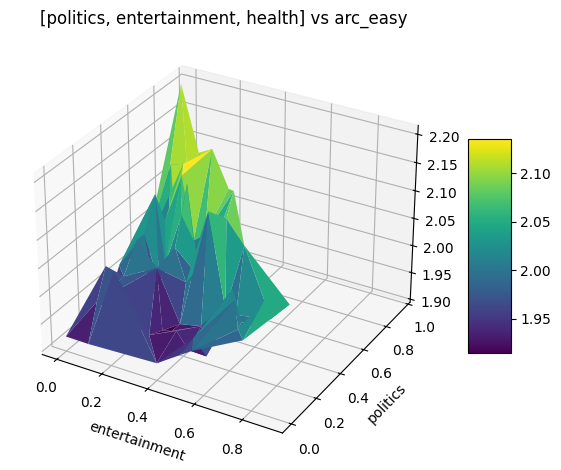

In [113]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# Example data (you can replace with your actual arrays)
# X is shape (64, 3)
# Y is shape (64,)
# For demonstration:
# X = np.random.rand(64, 3)
# Y = np.random.rand(64)

# Extract coordinates
idx1 = 1
idx2 = 0
x = X[:, idx1]
y = X[:, idx2]
z = Y.flatten()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

# Optional: Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Labels
ax.set_xlabel(ratios.columns[2:][idx1])
ax.set_ylabel(ratios.columns[2:][idx2])
plt.title('[politics, entertainment, health] vs arc_easy')

plt.tight_layout()
plt.show()